Basic Statistics:
count    100.000000
mean      19.994939
std        0.287302
min       19.319476
25%       19.835943
50%       20.006272
75%       20.120014
max       21.082877
Name: time, dtype: float64


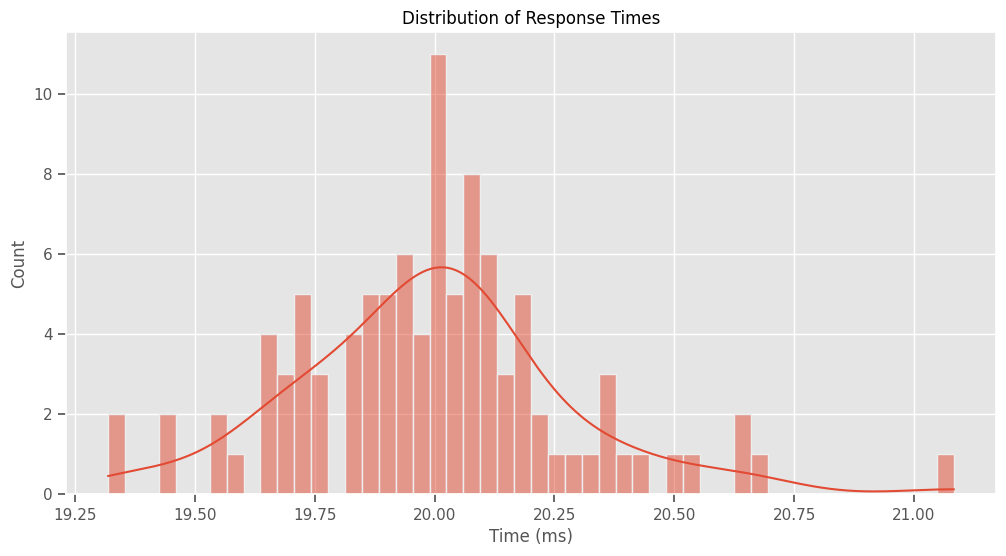

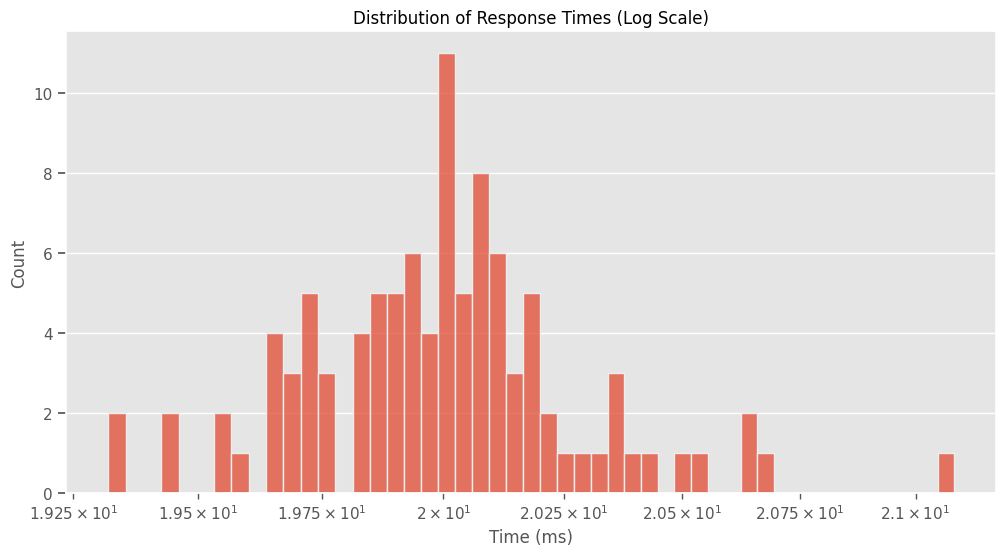


Percentiles:
 percentile   time_ms
       50.0 20.006272
       75.0 20.120014
       90.0 20.343716
       95.0 20.490774
       99.0 20.686245
       99.9 21.043214


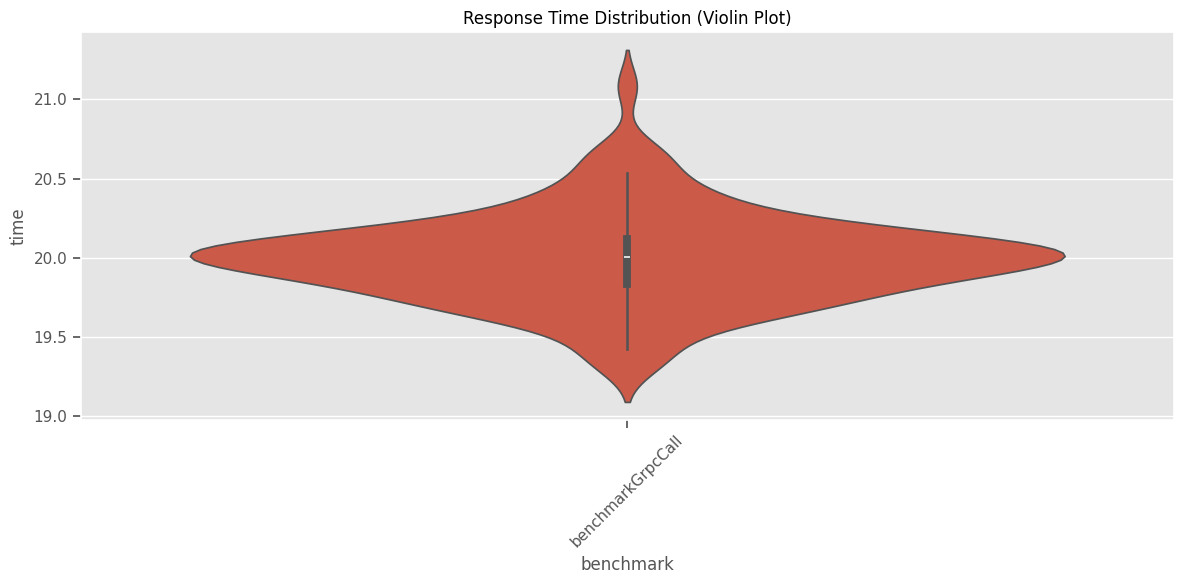


Summary by Benchmark:
                   count   mean   std    p50    p95    p99
benchmark                                                 
benchmarkGrpcCall    100  19.99  0.29  20.01  20.49  20.69


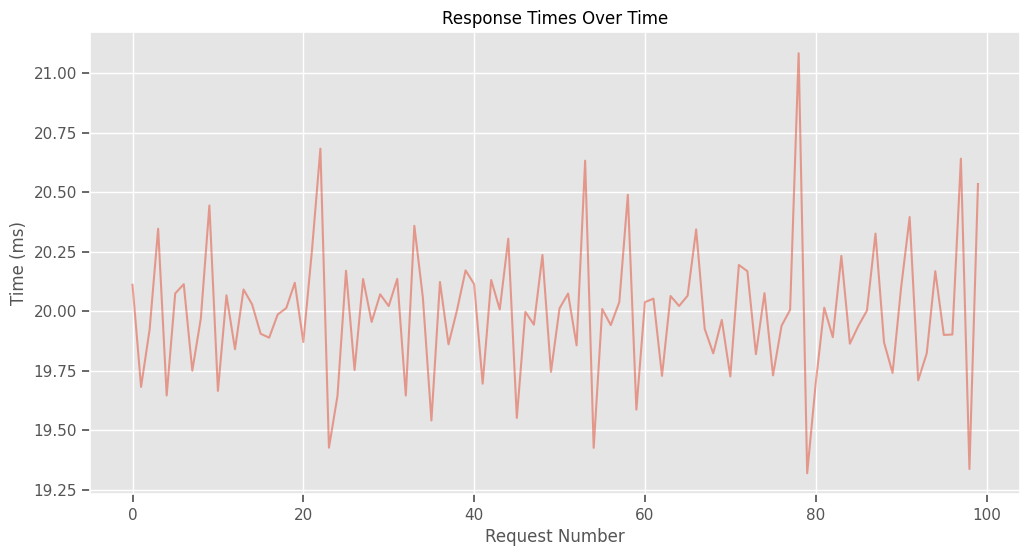

In [2]:
# Load required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style for better-looking plots
plt.style.use('ggplot')  # or try 'bmh', 'fivethirtyeight'
sns.set_context("notebook")

# Load JMH results
# Update this path to your results.json location
with open('build/reports/jmh/results.json') as f:
    data = json.load(f)

# Extract all raw times
all_times = []
benchmark_names = []

for benchmark in data:
    name = benchmark['benchmark'].split('.')[-1]  # Get just the method name
    # JMH stores each iteration's results as a list of lists
    # Flatten all the raw data points
    times = [time for iteration in benchmark['primaryMetric']['rawData'] 
            for time in iteration]
    all_times.extend(times)
    benchmark_names.extend([name] * len(times))

# Create DataFrame
df = pd.DataFrame({
    'benchmark': benchmark_names,
    'time': all_times
})

# Print basic statistics
print("Basic Statistics:")
print(df['time'].describe())

# Create histogram with KDE
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='time', bins=50, kde=True)
plt.title('Distribution of Response Times')
plt.xlabel('Time (ms)')
plt.ylabel('Count')
plt.show()

# Log scale histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='time', bins=50)
plt.xscale('log')
plt.title('Distribution of Response Times (Log Scale)')
plt.xlabel('Time (ms)')
plt.ylabel('Count')
plt.show()

# Calculate percentiles
percentiles = [50, 75, 90, 95, 99, 99.9]
perc_values = np.percentile(df['time'], percentiles)
perc_df = pd.DataFrame({
    'percentile': percentiles,
    'time_ms': perc_values
})
print("\nPercentiles:")
print(perc_df.to_string(index=False))

# Box plot if multiple benchmarks exist
if len(df['benchmark'].unique()) > 1:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='benchmark', y='time')
    plt.xticks(rotation=45)
    plt.title('Response Time Distribution by Benchmark')
    plt.tight_layout()
    plt.show()

# Optional: Create violin plot for more detailed distribution view
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='benchmark', y='time')
plt.xticks(rotation=45)
plt.title('Response Time Distribution (Violin Plot)')
plt.tight_layout()
plt.show()

# Calculate summary statistics by benchmark
print("\nSummary by Benchmark:")
summary = df.groupby('benchmark')['time'].agg([
    'count',
    'mean',
    'std',
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 95),
    lambda x: np.percentile(x, 99)
]).round(2)
summary.columns = ['count', 'mean', 'std', 'p50', 'p95', 'p99']
print(summary)

# Optional: Time series plot to check for any trends
plt.figure(figsize=(12, 6))
plt.plot(df['time'].reset_index(drop=True), alpha=0.5)
plt.title('Response Times Over Time')
plt.xlabel('Request Number')
plt.ylabel('Time (ms)')
plt.show()

# Distribution comparison if multiple benchmarks
if len(df['benchmark'].unique()) > 1:
    plt.figure(figsize=(12, 6))
    for benchmark in df['benchmark'].unique():
        sns.kdeplot(data=df[df['benchmark'] == benchmark], x='time', label=benchmark)
    plt.title('Response Time Distribution by Benchmark (KDE)')
    plt.xlabel('Time (ms)')
    plt.legend()
    plt.show()